In [1]:
# To disable `warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)`
import warnings
warnings.filterwarnings('ignore')

## 1. What is CVXPY?

CVXPY is a Python-embedded modeling language for convex optimization problems. It automatically transforms the problem into standard form, calls a solver, and unpacks the results.

In [2]:
import cvxpy as cp

# Create two scalar optimization variables.
x = cp.Variable()
y = cp.Variable()

# Form objective.
objective = cp.Minimize((x - y)**2)

# Create two constraints.
constraints = [x + y == 1, x - y >= 1]

# Form and solve problem.
prob = cp.Problem(objective, constraints)
prob.solve()  # Returns the optimal value.

print(f"""\
status: {prob.status}
optimal value: {prob.value}
optimal variables:
    x = {x.value}
    y = {y.value}
""")

status: optimal
optimal value: 1.0
optimal variables:
    x = 1.0
    y = 1.570086213240983e-22



The status, which was assigned a value "__optimal__" by the solve method, tells us the problem was solved successfully. The optimal value (basically 1 here) is the minimum value of the objective over all choices of variables that satisfy the constraints. The last thing printed gives values of x and y (basically 1 and 0 respectively) that achieve the optimal objective.

`prob.solve()` returns the optimal value and updates `prob.status`, `prob.value`, and the `value` field of all the variables in the problem.

### Changing the problem

__Problems__ are immutable, meaning they cannot be changed after they are created. To change the objective or constraints, create a new problem.

In [3]:
# Replace the objective.
prob2 = cp.Problem(cp.Maximize(x + y), prob.constraints)
print(f"optimal value: {prob2.solve()}")

# Replace the constraint (x + y == 1).
constraints = [x + y <= 3] + prob2.constraints[1:]
prob3 = cp.Problem(prob2.objective, constraints)
print(f"optimal value: {prob3.solve()}")

optimal value: 0.9999999999945575
optimal value: 2.9999999999746754


### Infeasible and unbounded problems

If a problem is infeasible or unbounded, the status field will be set to "__infeasible__" or "__unbounded__", respectively. The value fields of the problem variables are not updated.

In [4]:
import cvxpy as cp

x = cp.Variable()

# An infeasible problem.
prob = cp.Problem(cp.Minimize(x), [x >= 1, x <= 0])
prob.solve()

print(f"""\
status: {prob.status}
optimal value: {prob.value}
""")

# An unbounded problem.
prob = cp.Problem(cp.Minimize(x))
prob.solve()

print(f"""\
status: {prob.status}
optimal value: {prob.value}
""")

status: infeasible
optimal value: inf

status: unbounded
optimal value: -inf



Notice that for a minimization problem the optimal value is `inf` if infeasible and `-inf` if unbounded. For maximization problems the opposite is true.

### Other problem statuses

If the solver called by CVXPY solves the problem but to a lower accuracy than desired, the problem status indicates the lower accuracy achieved. The statuses indicating lower accuracy are

- "__optimal inaccurate__"
- "__unbounded inaccurate__"
- "__infeasible inaccurate__"

The problem variables are updated as usual for the type of solution found (i.e., __optimal__, __unbounded__, or __infeasible__).

If the solver completely fails to solve the problem, CVXPY throws a `SolverError` exception. If this happens you should try using other solvers. See the discussion of [Choosing a solver](https://www.cvxpy.org/tutorial/advanced/index.html#solvers) for details.

CVXPY provides the following constants as aliases for the different status strings:

- `OPTIMAL`
- `INFEASIBLE`
- `UNBOUNDED`
- `OPTIMAL_INACCURATE`
- `INFEASIBLE_INACCURATE`
- `UNBOUNDED_INACCURATE`
- `INFEASIBLE_OR_UNBOUNDED`

To test if a problem was solved successfully, you would use
```
prob.status == OPTIMAL
```
The status `INFEASIBLE_OR_UNBOUNDED` is rare. It’s used when a solver was able to determine that the problem was either infeasible or unbounded, but could not tell which. You can determine the precise status by re-solving the problem where you set the objective function to a constant (e.g., `objective = cp.Minimize(0)`). If the new problem is solved with status code `INFEASIBLE_OR_UNBOUNDED` then the original problem was infeasible. If the new problem is solved with status `OPTIMAL` then the original problem was unbounded.

### Vectors and matrices

__Variables__ can be scalars, vectors, or matrices, meaning they are 0, 1, or 2 dimensional.

In [5]:
# A scalar variable.
a = cp.Variable()

# Vector variable with shape (5,).
x = cp.Variable(5)

# Matrix variable with shape (4, 7).
A = cp.Variable((4, 7))

a, x, A

(Variable((), var112), Variable((5,), var113), Variable((4, 7), var114))

You can use your numeric library of choice to construct matrix and vector constants. For instance, if x is a CVXPY Variable in the expression `A @ x + b`, `A` and `b` could be Numpy ndarrays, SciPy sparse matrices, etc. `A` and `b` could even be different types.

Currently the following types may be <u>used as constants</u>:

- NumPy ndarrays
- NumPy matrices
- SciPy sparse matrices

Here’s an example of a CVXPY problem with vectors and matrices:

In [6]:
# Solves a bounded least-squares problem.

import numpy as np
import cvxpy as cp

# Problem data.
m = 10
n = 5

rng = np.random.default_rng(1)
A = rng.standard_normal((m, n))
b = rng.standard_normal(m)

# Construct the problem.
x = cp.Variable(n)

objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

print(f"""\
optimal value: {prob.solve()}
optimal variables: (a numpy ndarray)
    {x.value}
""")

optimal value: 1.716426317778556
optimal variables: (a numpy ndarray)
    [ 3.83404177e-01  9.09989000e-01  9.20222924e-02  4.93360339e-01
 -6.78466468e-22]



### Constraints

As shown in the example code, you can use `==`, `<=`, and `>=` to construct constraints in CVXPY. Equality and inequality constraints are elementwise, whether they involve scalars, vectors, or matrices. For example, together the constraints `0 <= x` and `x <= 1` mean that every entry of `x` is between 0 and 1.

If you want matrix inequalities that represent semi-definite cone constraints, see [Semidefinite matrices](https://www.cvxpy.org/tutorial/advanced/index.html#semidefinite). The section explains how to express a semi-definite cone inequality.

You <u>cannot construct</u> inequalities with `<` and `>`. Strict inequalities don't make sense in a real world setting. Also, you <u>cannot chain</u> constraints together, e.g., `0 <= x <= 1` or `x == y == 2`. The Python interpreter treats chained constraints in such a way that CVXPY cannot capture them. CVXPY will raise an exception if you write a chained constraint.

### Parameters

__Parameters__ are symbolic representations of constants. The purpose of parameters is to <u>change the value of a constant in a problem without reconstructing the entire problem</u>. In many cases, solving a parametrized program multiple times can be substantially faster than repeatedly solving a new problem: after reading this section, be sure to read the tutorial on [Disciplined Parametrized Programming](https://www.cvxpy.org/tutorial/advanced/index.html#dpp) (DPP).

Parameters can be vectors or matrices, just like variables. When you create a parameter you have the option of specifying attributes such as the sign of the parameter's entries, whether the parameter is symmetric, etc. These attributes are used in [Disciplined Convex Programming](https://www.cvxpy.org/tutorial/dcp/index.html#dcp) and are unknown unless specified. Parameters can be assigned a constant value any time after they are created. The constant value must have the same dimensions and attributes as those specified when the parameter was created.

In [7]:
# Positive scalar parameter.
m = cp.Parameter(nonneg=True)

# Column vector parameter with unknown sign (by default).
c = cp.Parameter(5)

# Matrix parameter with negative entries.
G = cp.Parameter((4, 7), nonpos=True)

# Assigns a constant value to G.
G.value = -np.ones((4, 7))

m, c, G

(Parameter((), nonneg=True), Parameter((5,)), Parameter((4, 7), nonpos=True))

You can initialize a parameter with a value. The following code segments are equivalent:

In [8]:
# Create parameter, then assign value.
rho = cp.Parameter(nonneg=True)
rho.value = 2

# Initialize parameter with a value.
rho = cp.Parameter(nonneg=True, value=2)

Computing trade-off curves is a common use of parameters. The example below computes a trade-off curve for a LASSO problem.

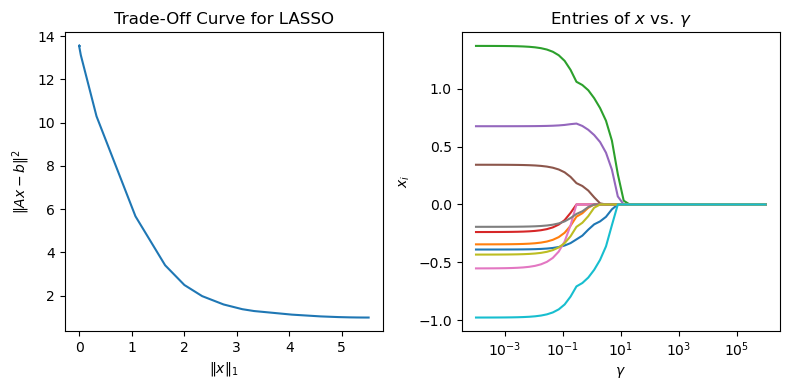

In [9]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Problem data.
n = 15
m = 10

rng = np.random.default_rng(1)
A = rng.standard_normal((n, m))
b = rng.standard_normal(n)

# gamma must be nonnegative due to DCP rules.
gamma = cp.Parameter(nonneg=True)

# Construct the problem.
x = cp.Variable(m)
error = cp.sum_squares(A @ x - b)

objective = cp.Minimize(error + gamma * cp.norm(x, p=1))
prob = cp.Problem(objective)

# Construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
sq_penalty = []
l1_penalty = []
x_values = []

gamma_vals = np.logspace(-4, 6)
for val in gamma_vals:
    gamma.value = val
    prob.solve()
    # Use expr.value to get the numerical value of an expression in the problem.
    sq_penalty.append(error.value)
    l1_penalty.append(cp.norm(x, p=1).value)
    x_values.append(x.value)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))

# Plot trade-off curve.
ax1.plot(l1_penalty, sq_penalty)
ax1.set_xlabel("$\|x\|_1$")
ax1.set_ylabel("$\|Ax-b\|^2$")
ax1.set_title("Trade-Off Curve for LASSO")

# Plot entries of x vs. gamma.
for i in range(m):
    ax2.plot(gamma_vals, [xi[i] for xi in x_values])
ax2.set_xscale("log")
ax2.set_xlabel("$\gamma$")
ax2.set_ylabel("$x_i$")
ax2.set_title("Entries of $x$ vs. $\gamma$")

fig.tight_layout()

Trade-off curves can easily be computed in parallel. The code below computes in parallel the optimal x for each 
 in the LASSO problem above.

In [10]:
from multiprocessing import Pool

# Assign a value to gamma and find the optimal x.
def get_x(gamma_value):
    gamma.value = gamma_value
    prob.solve()
    return x.value

gamma_vals = np.logspace(-4, 6, num=100)

In [11]:
# Parallel computation (set to 1 process here).
pool = Pool(processes=1)
%timeit x_values = pool.map(get_x, gamma_vals)

210 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
# Parallel computation (set to 10 process here).
pool = Pool(processes=10)
%timeit x_values = pool.map(get_x, gamma_vals)

32.4 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
